In [43]:
{-# LANGUAGE FlexibleContexts TypeFamilies #-}
import Diagrams.Backend.Cairo.CmdLine

In [44]:
import Diagrams.Prelude
import Graphics.SVGFonts
import Graphics.SVGFonts.ReadFont (PreparedFont)

import Diagrams.Core.Points -- needed to work around bug in GHC 7.4

Each series is a label and a list of points (x-y pairs).  Each series
will be drawn as a separate line, with its own combination of colour,
dashing pattern and shape.



In [45]:
type Pt = (Double, Double)
type Points = [Pt]

dataSeries :: [(String,Points)]
dataSeries =
  [ ("upward",   zip [0.0, 1.0 .. 10.0] [0.0, 1.0 .. 10.0])
  , ("downward", zip [0.0, 1.0 .. 10.0] [10.0, 9.0 .. 0.0])
  , ("cycle",    zip [0.0, 1.0 .. 10.0] (cycle [3,4,5]))
  , ("arbitrary", [(2,4), (4,2), (5,4), (10,5)])
  , ("sin",      map (\x -> (x, 8+sin x)) [0.0, 0.5 .. 10.0])
  ]

type Dia = Diagram B

The final diagram is the chart with the legend next to it.




In [67]:
example :: IO Dia
example = do
  lin2_ <- lin2
  return . centerXY $
    (centerY (chart lin2_ (map snd dataSeries) plotStyles [0,2,4,6,8,10] [0,2,4,6,8,10])
     ||| strutX 1
     ||| centerY (legend lin2_ plotStyles (map fst dataSeries)))
     `atop` square 12 # translateX 5 # scaleY 0.85 -- border

The size of the chart, in logical units.



In [47]:
h,w :: Double
h = 7
w = 7

The chart is made of the data series, the outer box, and the
horizontal and vertical axes markings.

"dataToFrac" converts points from the "data" space [0..10] into the
[0..1] range.



In [64]:
chart :: PreparedFont Double -> [Points] -> [(Dia, Dia -> Dia)] -> [Double] -> [Double] -> Dia
chart font series styles xs ys = mconcat
  [ plotMany styles series dataToFrac
  , horizticks font (map (\x -> ((x-minx)/xrange, showFloor x)) xs)
  , vertticks  font (map (\y -> ((y-miny)/yrange, showFloor y)) ys)
  , box
  ]
  where maxx = last xs
        minx = head xs
        maxy = last ys
        miny = head ys
        xrange = maxx-minx
        yrange = maxy-miny
        dataToFrac (x,y) = ((x-minx)/xrange, (y-miny)/yrange)
        showFloor = show . (floor :: Double -> Integer)

Plot a single data series.  A "shape" is drawn at every data point,
and straight lines are drawn between points.



In [49]:
plot :: ((Double, Double) -> (Double, Double)) -> Dia -> (Dia -> Dia) -> Points -> Dia
plot dataToFrac shape lineStyle ps =
    let scalify (x,y) = (x*w,y*h)
        ps' = map (p2 . scalify . dataToFrac) ps
    in (strokeP $ fromVertices ps') # lineStyle
         `beneath` mconcat [ shape # moveTo p | p <- ps' ]


Line 5: Move brackets to avoid $
Found:
(strokeP $ fromVertices ps') # lineStyle
Why not:
strokeP (fromVertices ps') # lineStyle

Plot many data series using the given list of styles.



In [63]:
plotMany :: [(Dia, Dia -> Dia)] -> [Points] -> (Pt -> Pt) -> Dia
plotMany styles seriesList dataToFrac =
    mconcat $ zipWith (uncurry (plot dataToFrac)) (styles ++ plotStyles) seriesList


A string of text, converted to a path and filled.



In [51]:
text' :: PreparedFont Double -> String -> Dia
text' font s = (strokeP $ textSVG' (TextOpts font INSIDE_H KERN False 0.4 0.4) s) # fc black # lw none


Line 2: Move brackets to avoid $
Found:
(strokeP $ textSVG' (TextOpts font INSIDE_H KERN False 0.4 0.4) s)
  # fc black
Why not:
strokeP (textSVG' (TextOpts font INSIDE_H KERN False 0.4 0.4) s)
  # fc black

The chart's legend.  Each label is drawn next to a little example of
how the line looks in the chart.



In [66]:
legend :: PreparedFont Double -> [(Dia, Dia -> Dia)] -> [String] -> Dia
legend font styles labels = centerXY $
    vcat' with {_sep=0.15} $
      map (\(l,s) -> littleLine s ||| strutX 0.4 ||| text' font l # alignL)
        (zip labels (styles ++ plotStyles))
  where littleLine (d,l) = (strokeP $ fromVertices [ 0^&0, 1^&0 ]) # l
                           <> d # moveTo (0.5^&0)


Line 4: Use zipWith
Found:
map
  (\ (l, s) -> littleLine s ||| strutX 0.4 ||| text' font l # alignL)
  (zip labels (styles ++ plotStyles))
Why not:
zipWith
  (curry
     (\ (l, s)
        -> littleLine s ||| strutX 0.4 ||| text' font l # alignL))
  labels (styles ++ plotStyles)Line 6: Move brackets to avoid $
Found:
(strokeP $ fromVertices [0 ^& 0, 1 ^& 0]) # l
Why not:
strokeP (fromVertices [0 ^& 0, 1 ^& 0]) # l

The outer box is just a rectangle.



In [53]:
box :: Dia
box = strokeLoop . closeLine . fromVertices $ [ 0^&0, 0^&h, w^&h, w^&0 ]


Each tick on the vertical axis has a text part, a solid line on the
left, a solid line on the right, and a long dashed line from left to
right.



In [54]:
vertticks :: PreparedFont Double -> [(Double, String)] -> Dia
vertticks font pairs =
    let textBits = mconcat [ text' font t # alignR # moveTo ((-0.2)^&(y*h)) | (y,t) <- pairs ]
        tickBits =    mconcat [ fromVertices [ 0^&(y*h), 0.1    ^&(y*h) ] | (y,_) <- pairs ]
                   <> mconcat [ fromVertices [ w^&(y*h), (w-0.1)^&(y*h) ] | (y,_) <- pairs ]
                   <> mconcat [ fromVertices [ 0^&(y*h), w^&(y*h)       ] # lc gray # dashingG [ 0.1, 0.1 ] 0 | (y,_) <- pairs ]
    in textBits <> tickBits


(Similar for the horizontal axis.)



In [60]:
horizticks :: PreparedFont Double -> [(Double, String)] -> Dia
horizticks font pairs =
    let textBits = mconcat [ text' font t # moveTo ((x*w)^&(-0.3)) | (x,t) <- pairs ]
        tickBits =    mconcat [ fromVertices [ (x*w)^&0, (x*w)^&0.1     ] | (x,_) <- pairs ]
                   <> mconcat [ fromVertices [ (x*w)^&h, (x*w)^&(h-0.1) ] | (x,_) <- pairs ]
                   <> mconcat [ fromVertices [ (x*w)^&0, (x*w)^&h       ] # lc gray # dashingG [ 0.1, 0.1 ] 0 | (x,_) <- pairs ]
    in textBits <> tickBits

A dot style is a shape (any diagram) and a boolean indicating whether
the shape should be filled, a line style is a dashing pattern, and a
colour style is just a colour.  These three combined give a "style".



In [59]:
newtype Fill = Fill Bool
type Shape = Dia
type DotStyle = (Shape, Fill)
type LineStyle = Dia -> Dia

plotStyles :: [ (Shape, LineStyle) ]
plotStyles = zipWith3 combineStyles dotStyles colourStyles lineStyles

combineStyles :: DotStyle -> Colour Double -> LineStyle -> (Shape, LineStyle)
combineStyles (d,Fill f) c l =
  ( d # (if f then fcA (c `withOpacity` 0.5) else id) # lc c, lc c . l )

-- The dot styles.
dotStyles :: [DotStyle]
dotStyles = cycle $
    let shapes = map (strokeP)
           [ circle 0.07
           , square 0.1
           , eqTriangle 0.1
           , pentagon 0.1
           , cross 0.07
           , plus 0.07
           , star (StarSkip 2) (pentagon 0.1)
           ]
    in [ (s, Fill b) | b <- [True,False], s <- shapes ]

Line 16: Redundant bracket
Found:
(strokeP)
Why not:
strokeP

Some custom shapes.



In [37]:
cross :: Double -> Path V2 Double
cross x = fromVertices [ x^&(-x) , ((-x)^&x) ]
          <> fromVertices [ x^&x , ((-x)^&(-x)) ]

plus :: Double -> Path V2 Double
plus x = cross x # rotate (45 @@ deg)


Line 2: Redundant bracket
Found:
[x ^& (- x), ((- x) ^& x)]
Why not:
[x ^& (- x), (- x) ^& x]Line 3: Redundant bracket
Found:
[x ^& x, ((- x) ^& (- x))]
Why not:
[x ^& x, (- x) ^& (- x)]

The colour styles.



In [39]:
colourStyles :: [Colour Double]
colourStyles = cycle [ red, green, blue, brown ]


The line styles.



In [40]:
lineStyles :: [Dia -> Dia]
lineStyles = cycle
               [ id, dashingG [0.1,0.1] 0, dashingG [0.02,0.02] 0
               , dashingG [0.1,0.1,0.03,0.1] 0, dashingG [0.1,0.1,0.02,0.02,0.02,0.1] 0 ]


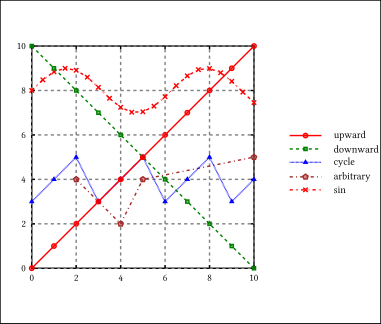

In [68]:
example